## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
import numpy as np
from numba import vectorize, float32, jit, cuda, int16
from math import log, exp
import matplotlib.pyplot as plt

In [2]:
A = np.array([2, 5, 10, 3, 8], dtype='float32')

@vectorize([float32(float32)], target='parallel', fastmath=True)
def log(x):
    return log(x)

@vectorize([float32(float32)], target='parallel', fastmath=True)
def exp(x):
    return exp(x)

print("Vectorized Log:", log(A))
print("Vectorized Exp:", exp(A))


Vectorized Log: [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
Vectorized Exp: [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

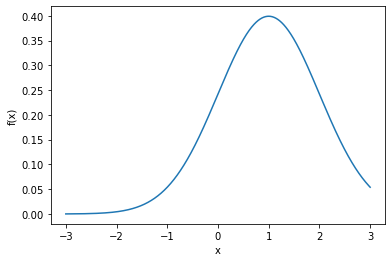

In [3]:
@vectorize([float32(float32)], target='parallel', fastmath=True)
def gaussian_pdf(x):
    sigma = 1.
    mean  = 1.
    return 1. / (np.sqrt(2 * np.pi) * sigma) * np.exp(-((x-mean)/sigma)**2 / 2)
    
N = 100000
xs = np.linspace(-3, 3, N, dtype='float32')


plt.plot(xs ,gaussian_pdf(xs) )
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

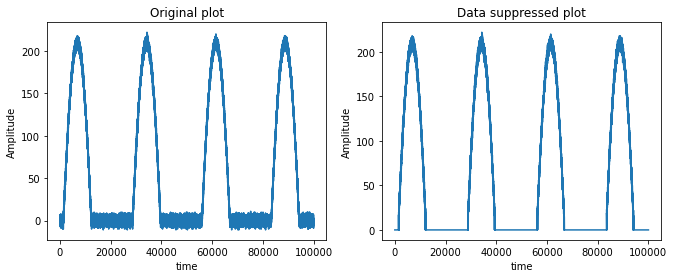

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt



n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

#put your code here:
@vectorize([int16(int16, int16)], target='parallel', fastmath=True)
def zero_suppression(sample, threshold):
    if sample < threshold:
        return 0
    else:
        return sample

plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
plt.plot(data)
plt.xlabel('time')
plt.ylabel('Amplitude')
plt.title('Original plot')

plt.subplot(1,2,2)
plt.plot(zero_suppression(data, 15))
plt.xlabel('time')
plt.ylabel('Amplitude')
plt.title('Data suppressed plot')

plt.show()

    

I execute the next exercises in google colab, since I have not installed Cuda yet.
Here is the codes.

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [5]:
seed=np.random.seed(123)
X = np.random.rand(3,3)
Y = np.random.rand(3,3)


@cuda.jit
def sigmoid_kernel(X,Y,result,a,c):
    row,col = cuda.grid(2)
    if row < result.shape[0] and col < result.shape[1]:
        tmp=0. # do the computation
        #for i in range(X.shape[0]):
        #    tmp += X[i, row] * Y[i, col]
        for i in range(result.shape[0]):
          tmp=X[i,row]*Y[i,col]
        result[row,col]=math.tanh(a*tmp+c)  
        
        
result=np.zeros((3,3), dtype='float64')
sigmoid_kernel[(1,1), (3,3)](X,Y, result, 1., 1.)
print(result)


##I tried it on colab, the output is:

#[[0.93831891 0.82713014 0.8249368 ]
# [0.90611953 0.80929271 0.80762268]
# [0.87521087 0.79606135 0.79481785]]

CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:

## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [ ]:
@cuda.jit(device=True)
def cos_func(a):
    a = math.cos(a)
    return a

@cuda.jit
def cos_kernel(io_array):
    x, y, z = cuda.grid(3)
    if x < io_array.shape[0] and y < io_array.shape[1] and z < io_array.shape[2]:
        io_array[x][y][z] = cos_func(io_array[x][y][z])
        
seed=np.random.seed(123)        
gen_matrix=np.random.normal(size=(256,256,256))
threadsperblock = 16

blockspergrid_x = (gen_matrix.shape[0] + (threadsperblock - 1)) // threadsperblock
blockspergrid_y = (gen_matrix.shape[1] + (threadsperblock - 1)) // threadsperblock
blockspergrid_z = (gen_matrix.shape[2] + (threadsperblock - 1)) // threadsperblock

blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

cos_kernel[threadsperblock, blockspergrid](gen_matrix)    
print(gen_matrix)

##it runs on colab

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [ ]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.random(size=(24,12))
B = np.random.random(size=(12,22))

# Configure the blocks
threadsperblock = (6,11) 
blockspergrid_x =4
blockspergrid_y = 2
blockspergrid = (blockspergrid_x, blockspergrid_y)

C = np.zeros((24,22))
matmul[blockspergrid, threadsperblock](A, B, C)


#it works on colab